# Weekly project

Today you are going to implement the last parts of the algorithm you started on monday. For reference you can see it below.

![title](algorithm_3.png)

It is a good idea to follow and track the steps in the algorithm in the below implementation. Only take one step at a time.

Once you have the algorithm up and running you can try with a larger dataset to see if your algorithm is able to maintain good accurracy over a longer distance. The larger dataset can be found here:
[Left images](https://dtudk-my.sharepoint.com/:u:/g/personal/evanb_dtu_dk/EQu8kmGBDDROtGJ7IkZB2tQBJrxmgY9t8LVM_JuEi83TYw)
[Right images](https://dtudk-my.sharepoint.com/:u:/g/personal/evanb_dtu_dk/EcKI_zrXTvpMulizidCZm4oBLJcQ_LTV9Zs6oQFF74JTRQ)

In [1]:
import numpy as np
import cv2 as cv2
from numpy.linalg import inv, pinv
import matplotlib.pyplot as plt
import time as t
from helpers import *

**1.2** The initial matching of keypoints in $I_{k-2}, I_{k-1}$.

In [2]:

def extract_keypoints_SIFT(img1, img2, K, baseline, verbose=False):
    """
    use SIFT to detect keypoint features and match between images.
    Includes a Lowes ratio test to improve performance.

    params:
        - img1, img2: images to match.
        - K: projection matrices for images
        - baseline: base translation between cameras.

    returns:
        - initial landmark points.
        - corresponding 2D points in img1.
    """
    # SURF IS DEAD! :(
    #surf = cv2.xfeatures2d.SURF_create()

    # 1 SIFT
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # 2 KNN match with two (best and second best)
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    # 3 Ratio test!
    kp1_indexes = []
    kp2_indexes = []
    good_matches= []
    for m,n in matches:
        if m.distance < 0.70*n.distance:
            good_matches.append([m])
            kp1_indexes.append(m.queryIdx)
            kp2_indexes.append(m.trainIdx)

    ## 4 extract the keypoints of the "good" matches
    kp1 = np.asarray(kp1)
    kp2 = np.asarray(kp2)
    match_points1 = [p.pt for p in kp1[kp1_indexes]]
    match_points2 = [p.pt for p in kp2[kp2_indexes]]

    p1 = np.array(match_points1).astype(np.float32)
    p2 = np.array(match_points2).astype(np.float32)

    ##############################
    ##### Do Triangulation #######
    ##############################
    #project the feature points to 3D with triangulation
    
    #projection matrix for Left and Right Image
    M_left = K.dot(np.hstack((np.eye(3), np.zeros((3, 1)))))
    M_rght = K.dot(np.hstack((np.eye(3), np.array([[-baseline, 0, 0]]).T)))
    P = cv2.triangulatePoints(M_left, M_rght, p1.T, p2.T)

    # Normalize homogeneous coordinates (P->Nx4  [N,4] is the normalizer/scale)
    P = P / P[3]
    land_points = P[:3]    
    if verbose:
        print("no. matches", len(matches))
        print("Good matches:", len(good_matches))

        print("Landmark points", land_points.T.shape)
        print("Reference points", p1.shape)
        verbose_img = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good_matches[:50],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        
        plt.figure(figsize=(15, 15));
        plt.title("50 first Reference points and matches")
        plt.imshow(verbose_img)
        plt.scatter(p1[:, 0], p1[:, 1], c="red", s=3)
        plt.show()

        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
        axs[0].set_title("2D points")
        axs[0].scatter(p1[:, 0], p1[:, 1], c="red", s=2)
        axs[0].scatter(p2[:, 0], p2[:, 1], c="blue", s=2)
        axs[0].invert_yaxis()

        axs[1].set_title("Landmark points")
        axs[1].scatter(land_points[0, :], land_points[1, :], s=2)
        axs[1].invert_yaxis()
        axs[1].set_xlim(-20,20)


    return land_points.T, p1

no. matches 3206
Good matches: 942
Landmark points (942, 3)
Reference points (942, 2)


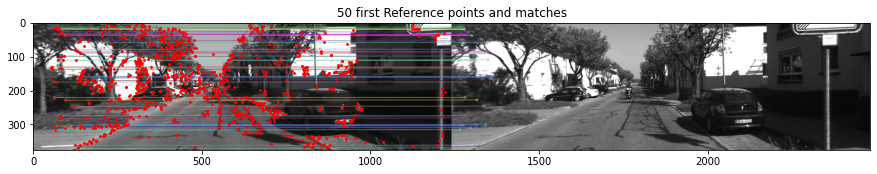

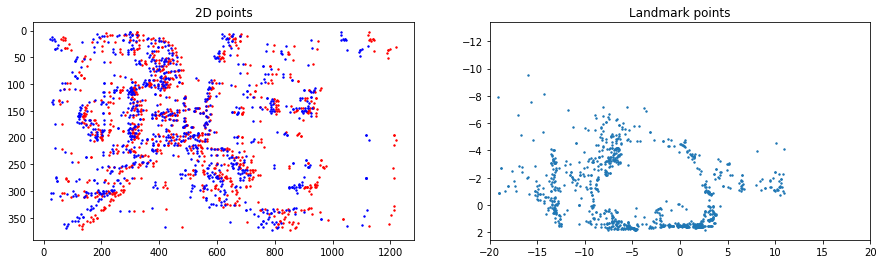

In [3]:
left_img = getLeftImage(0)
right_img = getRightImage(0)
K = getK()
baseline = 0.54

landmark_3D, reference_2D = extract_keypoints_SIFT(left_img, right_img, K, baseline, verbose=True)

**2.2** From exercises.

In [6]:
def featureTracking(prev_img, next_img, prev_points, world_points):
    """
    Use OpenCVs sparse optical flow matching to find the prev_points from the prev_img in the next_img = next_points.
    All points that could not be matched will be removed from "prev-points" and "world-points".
    """
    params = dict(winSize=(21, 21), # Window size of LK
                 maxLevel=3,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01))
    
    # 1 Sparse optical flow: using LK (Lucas Kanada)
    next_points, status, _ = cv2.calcOpticalFlowPyrLK(prev_img, next_img, prev_points, None, **params)
    
    # 2 Remove points that was not detected by both images, from 2D and 3D!
    good_indexes = np.where(np.any(status==1, axis=1))[0]
    next_points = next_points[good_indexes, :]
    world_points = world_points[good_indexes, :]
    prev_points = prev_points[good_indexes, :]

    return world_points, prev_points, next_points

**Putting it all together**

In [32]:
def playImageSequence(left_img, right_img, K):

    baseline = 0.54 # translation between first two images!

    ##### ################################# #######
    ##### Get 3D points Using Triangulation #######
    ##### #########################################
    """
    Implement step 1.2 and 1.3
    Store the features in 'reference_2D' and the 3D points (landmarks) in 'landmark_3D'
    """
    landmark_3D, reference_2D = extract_keypoints_SIFT(left_img, right_img, K, baseline)

    # reference
    reference_img = left_img

    # Groundtruth for plot
    truePose = getTruePose()
    traj = np.zeros((600, 600, 3), dtype=np.uint8)
    maxError = 0

    # The original camerar projection matrix is in zero coords.
    old_transform = np.hstack((np.eye(3), np.zeros((3, 1))))
    M_old = K.dot(old_transform)


    for i in range(1, 1400):
        '''
        step (2.1) - capture a new image
        '''
        print('image: ', i)
        curImage = getLeftImage(i)
        #curImage_R = getRightImage(i) # In 2D-3D we only need one new frame

        ##### ############################################################# #######
        ##### Calculate 2D and 3D feature correspndances in t=T-1, and t=T  #######
        ##### #####################################################################
        """
        TODO Match old and new 2D points. Remove unmatchable points from 2D and 3D lists.
        """
        landmark_3D, reference_2D, tracked_2Dpoints = featureTracking(reference_img, 
                                                                      curImage, 
                                                                      reference_2D,
                                                                      landmark_3D)

        ##### ################################# #######
        ##### Calculate relative pose using PNP #######
        ##### #########################################
        """
        Implement step 2.3)
        TODO Use PNP RANSAC to estimate R, t based on new matches and new 2D points
        """
        _, rvec, tvec, _ = cv2.solvePnPRansac(landmark_3D, tracked_2Dpoints, K, distCoeffs=None)

        ##### ####################################################### #######
        ##### Get Pose and Tranformation Matrix in world coordionates #######
        ##### ###############################################################
        rot, _ = cv2.Rodrigues(rvec)
        tvec = -rot.T.dot(tvec)  # coordinate transformation, from camera to world. What is the XYZ of the camera wrt World

        inv_transform = np.hstack((rot.T, tvec))  # inverse transform. A tranform projecting points from the camera frame to the world frame
        """NB: Now, the inv_transforms holds a transformation from cam1-->cam2 in 'world coordinates'.'"""

        ##### ################################# #######
        ##### Get 3D points Using Triangulation #######
        ##### #########################################
        # re-obtain the 3D points
        """
        Implement step 2.4)
        """
        # Find completely new keypoints!
        # 1 SIFT
        sift = cv2.SIFT_create()
        kp1, des1 = sift.detectAndCompute(reference_img, None)
        kp2, des2 = sift.detectAndCompute(curImage, None)

        # 2 KNN match with two (best and second best)
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(des1, des2, k=2)

        # 3 Ratio test!
        kp1_indexes = []
        kp2_indexes = []
        for m,n in matches:
            if m.distance < 0.70*n.distance:
                kp1_indexes.append(m.queryIdx)
                kp2_indexes.append(m.trainIdx)

        # 4 extract the keypoints of the "good" matches
        kp1 = np.asarray(kp1)
        kp2 = np.asarray(kp2)
        match_points1 = [p.pt for p in kp1[kp1_indexes]]
        match_points2 = [p.pt for p in kp2[kp2_indexes]]

        old_2D = np.array(match_points1).astype(np.float32)
        new_2D = np.array(match_points2).astype(np.float32)

        #################
        ###Triangulate###
        #################
        M_new = K.dot(np.hstack((rot, tvec))) # Projection matrix for new image
        P = cv2.triangulatePoints(M_old, M_new, old_2D.T, new_2D.T)

        # Update
        landmark_3D_new = -P[:3] / P[3]
        reference_2D_new = new_2D.copy()

                
        print(np.median(P))
        print(np.median(landmark_3D))
        print(np.median(landmark_3D_new))


        #################
        ###Triangulate###
        #################

        #Project the points from camera to world coordinates
        reference_2D = reference_2D_new.astype('float32')
        #landmark_3D_new = inv_transform@np.vstack((landmark_3D_new, np.ones((1, landmark_3D_new.shape[1]))))
        landmark_3D = landmark_3D_new.T.copy()

        ##### ####################### #######
        ##### Done, Next image please #######
        ##### ###############################
        reference_img = curImage.copy()
        M_old = M_new.copy()

        ##### ################################## #######
        ##### START OF Print and visualize stuff #######
        ##### ##########################################
        # draw images
        draw_x, draw_y = int(tvec[0]) + 300, 600-(int(tvec[2]) + 100);
        true_x, true_y = int(truePose[i][3]) + 300, 600-(int(truePose[i][11]) + 100)

        print("Our estimate", (draw_x, draw_y), type(draw_x), type(draw_y))
        print("True", (true_x, true_y), type(true_x), type(true_y))

        curError = np.sqrt(
            (tvec[0] - truePose[i][3]) ** 2 +
            (tvec[1] - truePose[i][7]) ** 2 +
            (tvec[2] - truePose[i][11]) ** 2)
        
        if (curError > maxError):
            maxError = curError

        #print(tvec[0],tvec[1],tvec[2], rvec[0], rvec[1], rvec[2])
        #print([truePose[i][3], truePose[i][7], truePose[i][11]])
        
        text = "Coordinates: x ={0:02f}m y = {1:02f}m z = {2:02f}m".format(float(tvec[0]), float(tvec[1]),
                                                                           float(tvec[2]));
        cv2.circle(traj, (draw_x, draw_y), 1, (255, 0, 0), 2);
        cv2.circle(traj, (true_x, true_y), 1, (0, 255, 0), 2);
        cv2.rectangle(traj, (10, 30), (550, 50), (0, 0, 0), cv2.FILLED);
        cv2.putText(traj, text, (10, 50), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255), 1, 8);

        h1, w1 = traj.shape[:2]
        h2, w2 = curImage.shape[:2]
        vis = np.zeros((max(h1, h2), w1 + w2, 3), np.uint8)
        vis[:h1, :w1, :3] = traj
        vis[:h2, w1:w1 + w2, :3] = np.dstack((np.dstack((curImage,curImage)),curImage))

        cv2.imshow("Trajectory", vis);
        k = cv2.waitKey(1) & 0xFF
        if k == 27: break


    cv2.waitKey(0)
    cv2.destroyAllWindows()
    print('Maximum Error: ', maxError)
    ##### ################################ #######
    ##### END OF Print and visualize stuff #######
    ##### ########################################

if __name__ == '__main__':
    left_img = getLeftImage(0)
    right_img = getRightImage(0)

    K = getK()

    playImageSequence(left_img, right_img, K)

image:  1
No. 2D matches: 902
0.025329068
1.3394423
1.3310243
Our estimate (300, 500) <class 'int'> <class 'int'>
True (300, 500) <class 'int'> <class 'int'>
image:  2
No. 2D matches: 1225
0.027091557
1.1704237
1.2736063
Our estimate (300, 499) <class 'int'> <class 'int'>
True (300, 499) <class 'int'> <class 'int'>
image:  3
No. 2D matches: 1241
0.028638748
1.2376579
1.1880825
Our estimate (300, 498) <class 'int'> <class 'int'>
True (300, 498) <class 'int'> <class 'int'>
image:  4
No. 2D matches: 1273
0.029527549
1.1470419
1.1226442
Our estimate (300, 498) <class 'int'> <class 'int'>
True (300, 497) <class 'int'> <class 'int'>
image:  5
No. 2D matches: 1265
0.028417105
0.9836964
0.9174886
Our estimate (300, 497) <class 'int'> <class 'int'>
True (300, 496) <class 'int'> <class 'int'>
image:  6
No. 2D matches: 1317
0.01462689
0.8622052
0.9991231
Our estimate (300, 496) <class 'int'> <class 'int'>
True (300, 495) <class 'int'> <class 'int'>
image:  7
No. 2D matches: 1301
-0.00912424
1.014

error: OpenCV(4.5.5) :-1: error: (-5:Bad argument) in function 'circle'
> Overload resolution failed:
>  - Can't parse 'center'. Sequence item with index 1 has a wrong type
>  - Can't parse 'center'. Sequence item with index 1 has a wrong type


# Challenge 
The current implementation only uses features computed at the current timestep. However, as we process more images we potentially have a lot of features from previous timesteps that are still valid. The challenge is to expand the `extract_keypoints_surf(..., refPoints)` function by giving it old reference points. You should then combine your freshly computed features with the old features and remove all duplicates. This requires you to keep track of old features and 3D points.

Hint 1: look in `helpers.py` for removing duplicates.

Hint 2: you are not interested in points that are behind you, so remember to remove points that are negative in the direction you move.

#### QUIZ 6 required some coding

In [ ]:
# EX6
rvec = np.array([[-0.05], [-1.51], [-0.00]])
tvec = np.array([[87.39], [-2.25], [-24.89]])
P_camera = np.array([[-6.71], [0.23], [21.59]])
# 
rot, _ = cv2.Rodrigues(rvec)
tvec = -rot.T.dot(tvec)
#
inv_transform = np.hstack((rot.T, tvec))
P_world = inv_transform.dot(np.vstack((P_camera, np.ones((1, P_camera.shape[1])))))
P_world

array([[40.71158446],
       [-1.98395975],
       [96.74699786]])